In [204]:
import torch
import os
from einops import rearrange
import torch.nn.functional as F
import math

from transformers.models.llama.modeling_llama import LlamaRotaryEmbedding, LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig

### Find the checkpoints

In [205]:
# reference files
fpath = "/data_ephemeral/sim/sharded_layers_405b_interval1/llama3_1_405b/distill_llama3_1_405b_lk_smd_wtk64_fd64_w01/"
files = [f for f in os.listdir(fpath) if f.endswith('.pt')]
ref_layer2file = {}
for file in files:
    start = file.split("in=")[1].split("-")[0].strip('.pt')
    end   = file.split("out=")[1].split("-")[0].strip('.pt')
    if int(start) == 0: start = int(end) - 1
    for i in range(int(start), int(end)+1):
        ref_layer2file[i] = fpath + file
print(f"{ref_layer2file[i]=}; {len(ref_layer2file)=}")

# trained files 
fpath = "/home/simarora/code/lolcats/checkpoints/dl-d=llama3_1_405b/distill_llama_405b_xent1_mse1000_lr1e-2-m=llama3_1_405b/distill_llama3_1_405b_lk_smd_wtk64_fd64_w01-f=llama3_1_405b"
layer2file = {}
for path in os.listdir(fpath): 
    new_path = fpath + '/' + path
    start = new_path.split("in=")[1].split("-")[0]
    end   = new_path.split("out=")[1].split("_")[0]
    # print(start, end)
    for ix, i in enumerate(range(int(start), int(end)+1)):
        layer2file[i] = {
            "path": new_path,
            "offset": ix
        }

print(f"{layer2file[i]=}; {len(layer2file)=}")

ref_layer2file[i]='/data_ephemeral/sim/sharded_layers_405b_interval1/llama3_1_405b/distill_llama3_1_405b_lk_smd_wtk64_fd64_w01/_scratch_rahul_models_Meta-Llama-3.1-405B-in=053-out=053.pt'; len(ref_layer2file)=110
layer2file[i]={'path': '/home/simarora/code/lolcats/checkpoints/dl-d=llama3_1_405b/distill_llama_405b_xent1_mse1000_lr1e-2-m=llama3_1_405b/distill_llama3_1_405b_lk_smd_wtk64_fd64_w01-f=llama3_1_405b/finetune_layer_mini_xent1_mse1000-s=0-se=0-re=0-in=000-out=008_distill.pt', 'offset': 8}; len(layer2file)=126


### Load the reference vs. trained for a good cria

In [218]:
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, cos, sin, position_ids=None, unsqueeze_dim=1):
    cos = cos.unsqueeze(unsqueeze_dim)
    sin = sin.unsqueeze(unsqueeze_dim)
    q_embed = (q * cos) + (rotate_half(q) * sin)
    k_embed = (k * cos) + (rotate_half(k) * sin)
    return q_embed, k_embed

def repeat_kv(hidden_states: torch.Tensor, n_rep: int) -> torch.Tensor:
    batch, num_key_value_heads, slen, head_dim = hidden_states.shape
    if n_rep == 1:
        return hidden_states
    hidden_states = hidden_states[:, :, None, :, :].expand(batch, num_key_value_heads, n_rep, slen, head_dim)
    return hidden_states.reshape(batch, num_key_value_heads * n_rep, slen, head_dim)

def get_masks(window_size: int, q_len: int, k_len: int, 
              device: torch.device) -> tuple[torch.Tensor]:
    """
    Return masks for softmax and linear attention terms
    -> 1 is include, 0 is ignore
    """
    kwargs = {'device': device, 'dtype': int}
    l = window_size
    m = math.ceil(max(q_len, k_len) / window_size)
    # Creates an n x n mask where n = window_size^2
    mask = torch.block_diag(*[torch.ones((l, l), )] * m)
    mask += torch.roll(mask, -l, -1) # this adds the terracing
    if mask.shape[0] > q_len:
        mask = mask[-q_len:]
    if mask.shape[1] > k_len:
        mask = mask[:, -k_len:]
    # Return softmax mask (window), linear attention mask
    mask = mask[None, None, ...]  # b, h, q_len, k_len
    return torch.tril(mask).to(**kwargs), torch.tril(1 - mask).to(**kwargs)

def quadratic_attention(q: torch.Tensor, k: torch.Tensor, 
                               f_q: torch.Tensor, f_k: torch.Tensor,
                               v: torch.Tensor,
                               window_factor: torch.Tensor,
                               linear_factor: torch.Tensor,
                               window_size: int,
                               eps: float = 1e-12,
                               mask_value: float=-1e8):
    """
    Hybrid attention combining sliding window and linear attentions
    """

    mask_window, mask_linear = get_masks(window_size, q.shape[-2], k.shape[-2], q.device)

    # print(q.shape, k.shape, f_q.shape, f_k.shape, v.shape)
    # torch.Size([1, 128, 1024, 128]) torch.Size([1, 128, 1024, 128]) torch.Size([1, 128, 1024, 128]) torch.Size([1, 128, 1024, 128]) torch.Size([1, 128, 1024, 128])

    # 1. Sliding window (softmax attention)
    a_sm = torch.einsum('bhmd,bhnd->bhmn', q.float(), k.float()) * (k.shape[-1] ** -0.5)
    a_sm = a_sm.masked_fill(~mask_window.bool(), mask_value)
    a_sm_max = torch.amax(a_sm, dim=-1, keepdim=True)
    a_sm   = window_factor * torch.exp(a_sm - a_sm_max)
    sum_sm = a_sm.sum(dim=-1, keepdim=True)

    # 2. Under window (linear attention)
    a_ln = torch.einsum('bhmd,bhnd->bhmn', f_q.float(), f_k.float())
    a_ln = linear_factor * a_ln.masked_fill(~mask_linear.bool(), 0)
    sum_ln = a_ln.sum(dim=-1, keepdim=True)

    # 3. Combine
    a = ((a_sm + a_ln) / (sum_sm + sum_ln)).to(q.dtype)  # Save attention weights
    y = torch.einsum('bhmn,bhnd->bhmd', a_sm + a_ln, v.float())
    y = (y / (sum_sm + sum_ln)).to(q.dtype)
    return y, a 

In [221]:
# load model weights
idx = 117
ref_path = ref_layer2file[idx]
ref = torch.load(ref_path)
trained = layer2file[idx]['path']
offset = layer2file[idx]['offset']
tr = torch.load(trained)

# extract weights
q_proj = ref['model.layers.0.self_attn.q_proj.weight']
k_proj = ref['model.layers.0.self_attn.k_proj.weight']
v_proj = ref['model.layers.0.self_attn.v_proj.weight']
o_proj = ref['model.layers.0.self_attn.o_proj.weight']
tr_q_map = tr['model_state_dict'][f'model.layers.{offset}.self_attn.feature_map_q.mlp.layer']
tr_k_map = tr['model_state_dict'][f'model.layers.{offset}.self_attn.feature_map_k.mlp.layer']
window_factors = tr['model_state_dict'][f'model.layers.{offset}.self_attn.window_factors']

# dimensions
bs, seqlen = 1, 1024
window_size = 64
print(f"{q_proj.shape=}; {k_proj.shape=}; {v_proj.shape}; {tr_q_map.shape=}; {tr_k_map.shape=}")
dim = q_proj.shape[0]
feature_dim = tr_q_map.shape[0] // 2
head_dim = 128

num_heads = dim // head_dim
num_key_value_heads = 8
num_key_value_groups = num_heads // num_key_value_heads
print(f"{num_heads=}; {num_key_value_heads=}; {num_key_value_groups=}")

# input
hidden_states = torch.randn(bs, seqlen, dim, dtype=torch.bfloat16)

rotary_emb = LlamaRotaryEmbedding(
    dim=dim,
    max_position_embeddings=8192,
    base=500000.0,
    scaling_factor=8.0,
    rope_type="llama3",
    config=LlamaConfig()
)

query_states = torch.einsum("de, ble -> ble", q_proj, hidden_states)
key_states = torch.einsum("de, ble -> bld", k_proj, hidden_states)
value_states = torch.einsum("de, ble -> bld", v_proj, hidden_states)

query_states = query_states.view(bs, seqlen, num_heads, head_dim).transpose(1, 2)
key_states = key_states.view(bs, seqlen, num_key_value_heads, head_dim).transpose(1, 2)
value_states = value_states.view(bs, seqlen, num_key_value_heads, head_dim).transpose(1, 2)
position_ids = torch.arange(seqlen, dtype=torch.long, device=hidden_states.device).unsqueeze(0).expand(bs, -1)

cos, sin = rotary_emb(value_states, position_ids)
query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

key_states = repeat_kv(key_states, num_key_value_groups)
value_states = repeat_kv(value_states, num_key_value_groups)

# linear attention lolcats
x = torch.einsum("hdf, bhld->bhlf", tr_q_map, query_states)
f_q = torch.cat([torch.softmax(x, dim=-1), torch.softmax(-x, dim=-1)], dim=-1).clamp(min=1e-12)
x = torch.einsum("hdf, bhld->bhlf", tr_k_map, key_states)
f_k = torch.cat([torch.softmax(x, dim=-1), torch.softmax(-x, dim=-1)], dim=-1).clamp(min=1e-12)
window_factors = F.sigmoid(window_factors)
linear_factors = 1
y_pred, a_pred = quadratic_attention(
    query_states, key_states,
     f_q, f_k, value_states,
    window_factors, linear_factors,
    window_size=window_size
)
y_pred = y_pred.transpose(1, 2).contiguous().view(bs, seqlen, dim)
y_pred = torch.einsum("de, ble -> ble", o_proj, y_pred)

# standard attention 
a_true = torch.nn.functional.scaled_dot_product_attention(
    query_states, key_states, value_states,
    attn_mask=None, dropout_p=0.0, is_causal=True,
)
y_true = a_true.transpose(1, 2).contiguous().view(bs, seqlen, dim)
y_true = torch.einsum("de, ble -> ble", o_proj, y_true)


mse = torch.nn.functional.mse_loss(y_pred.float(), y_true.float())
print(f"{mse=}")

q_proj.shape=torch.Size([16384, 16384]); k_proj.shape=torch.Size([1024, 16384]); torch.Size([1024, 16384]); tr_q_map.shape=torch.Size([128, 128, 64]); tr_k_map.shape=torch.Size([128, 128, 64])
num_heads=128; num_key_value_heads=8; num_key_value_groups=16
mse=tensor(0.4185)


In [222]:
# load model weights
layer2mse = {}

for idx in ref_layer2file.keys():
    try:
        ref_path = ref_layer2file[idx]
        ref = torch.load(ref_path)
        trained = layer2file[idx]['path']
        offset = layer2file[idx]['offset']
        tr = torch.load(trained)
    except:
        continue

    # extract weights
    q_proj = ref['model.layers.0.self_attn.q_proj.weight']
    k_proj = ref['model.layers.0.self_attn.k_proj.weight']
    v_proj = ref['model.layers.0.self_attn.v_proj.weight']
    o_proj = ref['model.layers.0.self_attn.o_proj.weight']
    tr_q_map = tr['model_state_dict'][f'model.layers.{offset}.self_attn.feature_map_q.mlp.layer']
    tr_k_map = tr['model_state_dict'][f'model.layers.{offset}.self_attn.feature_map_k.mlp.layer']
    window_factors = tr['model_state_dict'][f'model.layers.{offset}.self_attn.window_factors']

    # dimensions
    bs, seqlen = 1, 1024
    window_size = 64
    print(f"{q_proj.shape=}; {k_proj.shape=}; {v_proj.shape}; {tr_q_map.shape=}; {tr_k_map.shape=}")
    dim = q_proj.shape[0]
    feature_dim = tr_q_map.shape[0] // 2
    head_dim = 128

    num_heads = dim // head_dim
    num_key_value_heads = 8
    num_key_value_groups = num_heads // num_key_value_heads
    print(f"{num_heads=}; {num_key_value_heads=}; {num_key_value_groups=}")

    # input
    hidden_states = torch.randn(bs, seqlen, dim, dtype=torch.bfloat16)

    rotary_emb = LlamaRotaryEmbedding(
        dim=dim,
        max_position_embeddings=8192,
        base=500000.0,
        scaling_factor=8.0,
        rope_type="llama3",
        config=LlamaConfig()
    )

    query_states = torch.einsum("de, ble -> ble", q_proj, hidden_states)
    key_states = torch.einsum("de, ble -> bld", k_proj, hidden_states)
    value_states = torch.einsum("de, ble -> bld", v_proj, hidden_states)

    query_states = query_states.view(bs, seqlen, num_heads, head_dim).transpose(1, 2)
    key_states = key_states.view(bs, seqlen, num_key_value_heads, head_dim).transpose(1, 2)
    value_states = value_states.view(bs, seqlen, num_key_value_heads, head_dim).transpose(1, 2)
    position_ids = torch.arange(seqlen, dtype=torch.long, device=hidden_states.device).unsqueeze(0).expand(bs, -1)

    cos, sin = rotary_emb(value_states, position_ids)
    query_states, key_states = apply_rotary_pos_emb(query_states, key_states, cos, sin)

    key_states = repeat_kv(key_states, num_key_value_groups)
    value_states = repeat_kv(value_states, num_key_value_groups)

    # linear attention lolcats
    x = torch.einsum("hdf, bhld->bhlf", tr_q_map, query_states)
    f_q = torch.cat([torch.softmax(x, dim=-1), torch.softmax(-x, dim=-1)], dim=-1).clamp(min=1e-12)
    x = torch.einsum("hdf, bhld->bhlf", tr_k_map, key_states)
    f_k = torch.cat([torch.softmax(x, dim=-1), torch.softmax(-x, dim=-1)], dim=-1).clamp(min=1e-12)
    window_factors = F.sigmoid(window_factors)
    linear_factors = 1
    y_pred, a_pred = quadratic_attention(
        query_states, key_states,
        f_q, f_k, value_states,
        window_factors, linear_factors,
        window_size=window_size
    )
    y_pred = y_pred.transpose(1, 2).contiguous().view(bs, seqlen, dim)
    y_pred = torch.einsum("de, ble -> ble", o_proj, y_pred)

    # standard attention 
    a_true = torch.nn.functional.scaled_dot_product_attention(
        query_states, key_states, value_states,
        attn_mask=None, dropout_p=0.0, is_causal=True,
    )
    y_true = a_true.transpose(1, 2).contiguous().view(bs, seqlen, dim)
    y_true = torch.einsum("de, ble -> ble", o_proj, y_true)


    mse = torch.nn.functional.mse_loss(y_pred.float(), y_true.float())
    layer2mse[idx] = mse

/tmp/ipykernel_217131/4032937699.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ref = torch.load(ref_path)
/tmp/ipykernel_217131/4032937699.py:10: FutureWarning: You ar

q_proj.shape=torch.Size([16384, 16384]); k_proj.shape=torch.Size([1024, 16384]); torch.Size([1024, 16384]); tr_q_map.shape=torch.Size([128, 128, 64]); tr_k_map.shape=torch.Size([128, 128, 64])
num_heads=128; num_key_value_heads=8; num_key_value_groups=16
q_proj.shape=torch.Size([16384, 16384]); k_proj.shape=torch.Size([1024, 16384]); torch.Size([1024, 16384]); tr_q_map.shape=torch.Size([128, 128, 64]); tr_k_map.shape=torch.Size([128, 128, 64])
num_heads=128; num_key_value_heads=8; num_key_value_groups=16
q_proj.shape=torch.Size([16384, 16384]); k_proj.shape=torch.Size([1024, 16384]); torch.Size([1024, 16384]); tr_q_map.shape=torch.Size([128, 128, 64]); tr_k_map.shape=torch.Size([128, 128, 64])
num_heads=128; num_key_value_heads=8; num_key_value_groups=16
q_proj.shape=torch.Size([16384, 16384]); k_proj.shape=torch.Size([1024, 16384]); torch.Size([1024, 16384]); tr_q_map.shape=torch.Size([128, 128, 64]); tr_k_map.shape=torch.Size([128, 128, 64])
num_heads=128; num_key_value_heads=8; num_

Text(0, 0.5, 'MSE')

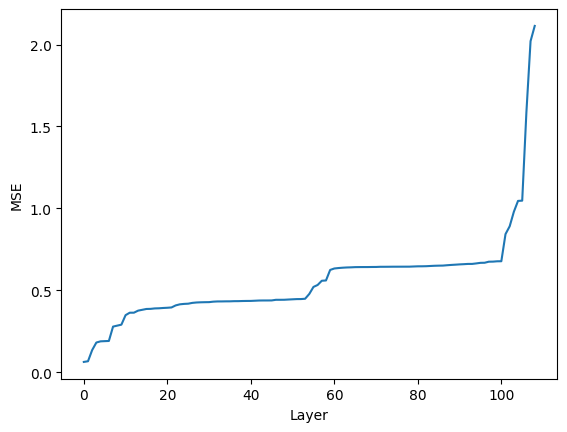

In [226]:
import matplotlib.pyplot as plt
# sort and plot 
layer2mse = {k: v for k, v in sorted(layer2mse.items(), key=lambda item: item[1])}
plt.plot(layer2mse.values())
plt.xlabel('Layer')
plt.ylabel('MSE')